In [34]:
%%bash

pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# New Section

In [35]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [36]:
data = "/content/mini_sparkify_event_data.json"
spotify_df = spark.read.json(data)

In [37]:
spotify_df.show(30)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [38]:
spotify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
print((spotify_df.count(), len(spotify_df.columns)))

(286500, 18)


In [40]:
spotify_df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

Missing Values


In [41]:
spotify_df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [42]:
from pyspark.sql.functions import udf, col, count, avg, stddev, isnull, when, isnan 

def counting_null(spotify_df):
    
    null_count = list()
    for col in spotify_df.columns:
        missing_values = spotify_df.filter((spotify_df[col] == "") \
                                   | spotify_df[col].isNull()
                                   | isnan(spotify_df[col])).count()
        null_count.append(missing_values)
    return null_count

In [43]:
def sumtable(spotify_df):
    summary = spotify_df.describe().toPandas().transpose()
    summary = summary.rename(columns=summary.iloc[0]).drop(summary.index[0])
    summary['null_count'] = counting_null(spotify_df)
    del spotify_df
    
    return summary

In [44]:
df_clean = spotify_df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(spotify_df["userId"] != "") # `userId` should not be empty string


In [45]:
#print("df:{}".format(spotify_df.count()))
#print("df_without_missing_id: {}".format(df_clean.count())) # no missing values

#if spotify_df.count() == df_clean.count():
#    print("No missing values with userId and sessionId")
#else:
#    print("{} rows have been removed.".format(spotify_df.count() - df_clean.count()))

In [46]:
# Get the count of rows in the original dataset
df_count = spotify_df.count()

# Get the count of rows in the cleaned dataset
clean_count = df_clean.count()
print("count_without_missing_id: {}".format(clean_count))
# Check if both counts are equal
if df_count == clean_count:
    print("No missing values with userId and sessionId")
else:
    # Find the difference in rows between the two datasets
    diff_df = spotify_df.exceptAll(df_clean)
    diff_count = diff_df.count()
    print("{} rows have been removed.".format(diff_count))


count_without_missing_id: 278154
8346 rows have been removed.


In [47]:
#spotify_df = spotify_df.fillna("None", subset=["artist", "song"])
#spotify_df = spotify_df.fillna(0, subset=["length"])
#spotify_df

In [48]:
from pyspark.sql.functions import when

spotify_df = spotify_df.withColumn("artist", when(spotify_df["artist"].isNull(), "None").otherwise(spotify_df["artist"]))
spotify_df = spotify_df.withColumn("song", when(spotify_df["song"].isNull(), "None").otherwise(spotify_df["song"]))
spotify_df = spotify_df.withColumn("length", when(spotify_df["length"].isNull(), 0).otherwise(spotify_df["length"]))
spotify_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [49]:
spotify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [50]:
spotify_df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [51]:
spotify_df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [52]:
from pyspark.sql.functions import when, col
spotify_df.filter(col("page") == "Cancellation Confirmation" ). \
    select("userId").distinct().count()

52

In [53]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, DateType, StringType

is_cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

customer_event_df = spotify_df.withColumn("churn", is_cancellation("page"))

window_func = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding,
                                                        Window.unboundedFollowing)
customer_event_df = customer_event_df.withColumn("churn", Fsum("churn").over(window_func))

In [54]:
spotify_df.filter("page = 'Cancellation Confirmation'").show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  None|Cancelled|   Adriel|     M|          104| Mendoza|   0.0| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|None|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  None|Cancelled|    Diego|     M|           56|   Mckee|   0.0| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|None|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  No

In [55]:
#flag_churned_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
#df_churned = spotify_df.withColumn("churned", flag_churned_event("page"))

In [56]:
from pyspark.sql.functions import when

df_churned = spotify_df.withColumn("churned", when(spotify_df.page == "Cancellation Confirmation", 1).otherwise(0))


In [57]:
print((df_churned.count(), len(df_churned.columns)))

(286500, 19)


In [58]:
#from pyspark.sql.functions import when

#df_churned = spotify_df.withColumn("churned", when(col("page") == "Cancellation Confirmation", 1).otherwise(0))


In [59]:
#churned_rate(from total event logs)
#churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
#print("churned: {:.2f}%".format(churned_rate * 100))

In [60]:
#from pyspark.sql.functions import expr

#churned_rate = df_churned.selectExpr("avg(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) as churned_rate").collect()[0]["churned_rate"]
#print("churned: {:.2f}%".format(churned_rate * 100))


#churned_rate = df_churned.groupBy("userId").agg({"churned": "max"}).agg({"max(churned)": "mean"}).collect()[0]["avg(max(churned))"]
#print("churned: {:.2f}%".format(churned_rate * 100))



In [61]:
churned_users = df_churned.filter(df_churned.page == "Cancellation Confirmation").select("userId").distinct().count()
total_users = df_churned.select("userId").distinct().count()

churned_rate = churned_users / total_users

print("churned: {:.2f}%".format(churned_rate * 100))


churned: 23.01%


In [62]:
df_churned.select(["userId", "gender", "level", "page", "status", "ts", "churned"]).show(30)

+------+------+-----+---------------+------+-------------+-------+
|userId|gender|level|           page|status|           ts|churned|
+------+------+-----+---------------+------+-------------+-------+
|    30|     M| paid|       NextSong|   200|1538352117000|      0|
|     9|     M| free|       NextSong|   200|1538352180000|      0|
|    30|     M| paid|       NextSong|   200|1538352394000|      0|
|     9|     M| free|       NextSong|   200|1538352416000|      0|
|    30|     M| paid|       NextSong|   200|1538352676000|      0|
|     9|     M| free|       NextSong|   200|1538352678000|      0|
|     9|     M| free|       NextSong|   200|1538352886000|      0|
|    30|     M| paid|       NextSong|   200|1538352899000|      0|
|    30|     M| paid|Add to Playlist|   200|1538352905000|      0|
|    30|     M| paid|       NextSong|   200|1538353084000|      0|
|     9|     M| free|       NextSong|   200|1538353146000|      0|
|     9|     M| free|    Roll Advert|   200|1538353150000|    

In [63]:
#from pyspark.sql.functions import asc
#from pyspark.sql.functions import sum as Fsum
#from pyspark.sql.window import Window
#from pyspark.sql.functions import max as Fmax
#from pyspark.sql.functions import min as Fmin

#windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
#df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))

#df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [64]:
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin

window_spec = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(window_spec))

df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

#churned_users = df_churn.filter(df_churn.churn == 1).count()
#total_users = df_churn.select("userId").distinct().count()

#print("Number of churned users: {}".format(churned_users))
#print("Total number of users: {}".format(total_users))

In [65]:
#from pyspark.sql.functions import col, sum as fsum, max as fmax, when
#from pyspark.sql.window import Window
# define the churn window
#windowval = Window.partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)

# create a column for the churn phase
#df_phase = df_churned.select("userId", "gender", "level", "page", "status", "ts", "churned",
 #                            fsum(when(col("churned") == 1, 1).otherwise(0)).over(windowval).alias("phase"))

# create a column for the churn label
#df_churn = df_phase.select("userId", "gender", "level", "page", "status", "ts", "churned", "phase",
  #                         fmax(col("churned")).over(Window.partitionBy("userId")).alias("churn"))

# show the resulting dataframe
#df_churn.show(20)


In [66]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"]).show(20)

+------+------+-----+---------------+------+-------------+-------+-----+-----+
|userId|gender|level|           page|status|           ts|churned|phase|churn|
+------+------+-----+---------------+------+-------------+-------+-----+-----+
|   100|     M| paid|       NextSong|   200|1538492662000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538492899000|      0|    0|    0|
|   100|     M| paid|    Thumbs Down|   307|1538492900000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493138000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493545000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493817000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538493984000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|1538494349000|      0|    0|    0|
|   100|     M| paid|Add to Playlist|   200|1538494374000|      0|    0|    0|
|   100|     M| paid|       NextSong|   200|15384946

In [67]:
d1 = df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churned", "phase", "churn"])
print((d1.count(), len(d1.columns)))

(44864, 9)


In [68]:
#churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
#print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
#print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

#from pyspark.sql.functions import col

#churned_user_count = df_churn.filter(col("churn") == 1).select("userId").distinct().count()
#total_user_count = clean_count.select("userId").distinct().count()
#churn_rate = churned_user_count / total_user_count * 100
#print("churned user count: {} (total: {})".format(churned_user_count, total_user_count))
#print("churned user rate: {:.2f}%".format(churn_rate))


#from pyspark.sql.functions import col

#churned_user_count = df_churn.filter(col("churn") == 1).select("userId").distinct().count()
#total_user_count = df_clean.select("userId").distinct().count()
#churn_rate = churned_user_count / total_user_count * 100
#print("churned user count: {} (total: {})".format(churned_user_count, total_user_count))
#print("churned user rate: {:.2f}%".format(churn_rate))


In [69]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
#total_user_count = df_churn.select("userId").dropDuplicates().count()
#total_user_count = df_churn.filter(col("page") != "Cancellation Confirmation").count()
print("churned user count: {} (total: {})".format(churned_user_count, df_clean.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_clean.count() * 100))



churned user count: 52 (total: 278154)
churned user rate: 0.02%


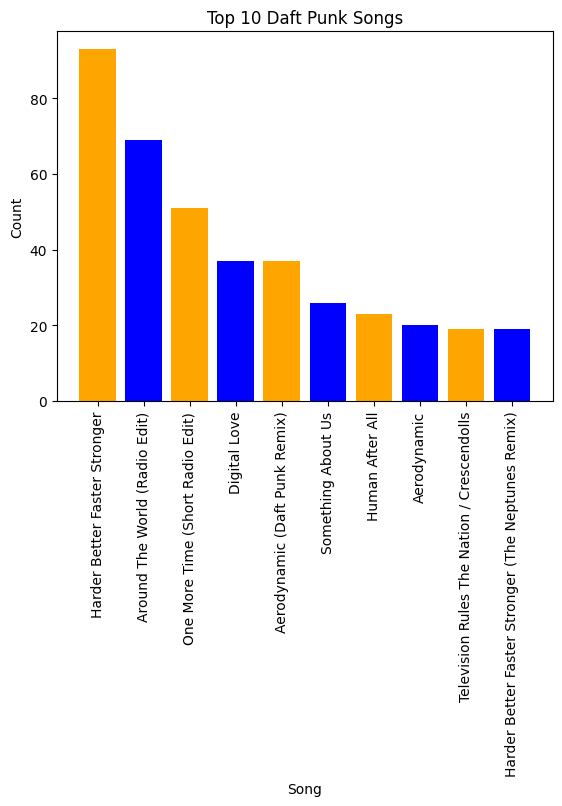

In [70]:
#What are the most popular songs by the artist in the dataset?

import matplotlib.pyplot as plt

song_df = spotify_df.filter(spotify_df.artist == "Daft Punk").groupBy("song").count().sort("count", ascending=False)

# Get the top 10 songs
top_songs = song_df.limit(10).toPandas()


# Create a bar chart to display the top 10 songs
colors = ['orange', 'blue']
plt.bar(top_songs["song"], top_songs["count"], color=colors)
plt.title("Top 10 Daft Punk Songs")
plt.xlabel("Song")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


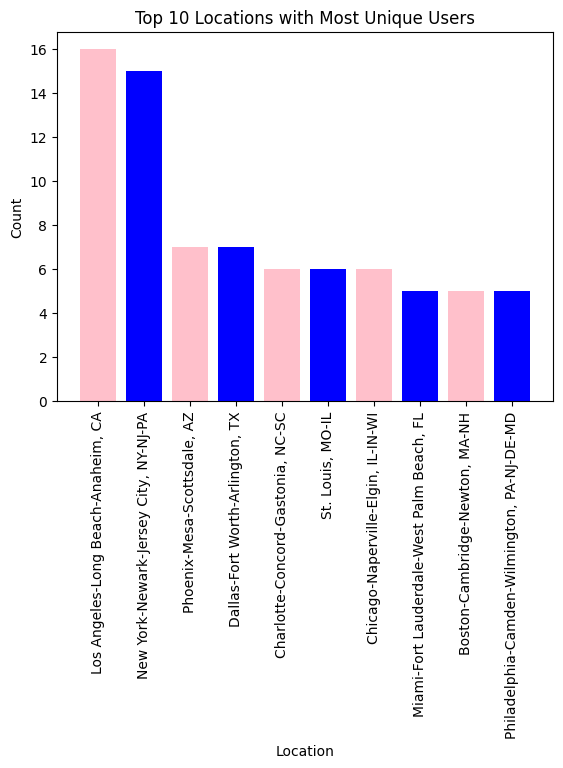

In [71]:
#Which locations have the highest number of users listening to music?

import matplotlib.pyplot as plt


location_df = spotify_df.dropDuplicates(["userId"]).groupBy("location").count().sort("count", ascending=False)


top_locations = location_df.limit(10).toPandas()

colors = ['pink', 'blue']
plt.bar(top_locations["location"], top_locations["count"],color=colors)
plt.title("Top 10 Locations with Most Unique Users")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


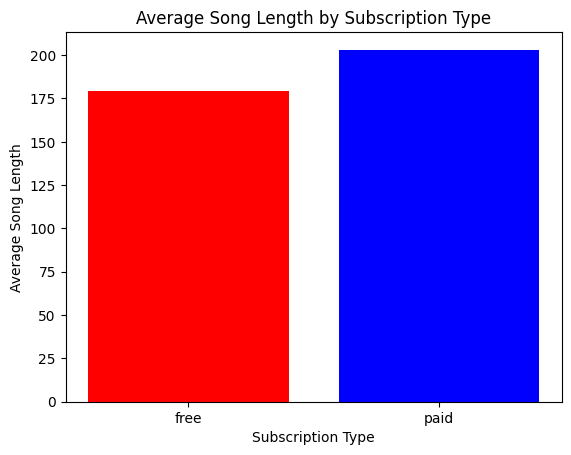

In [72]:

subscription_df = spotify_df.groupBy("level").avg("length")


subscription_df = subscription_df.toPandas()

colors = ['red', 'blue']
plt.bar(subscription_df["level"], subscription_df["avg(length)"],color=colors)
plt.title("Average Song Length by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Average Song Length")
plt.show()


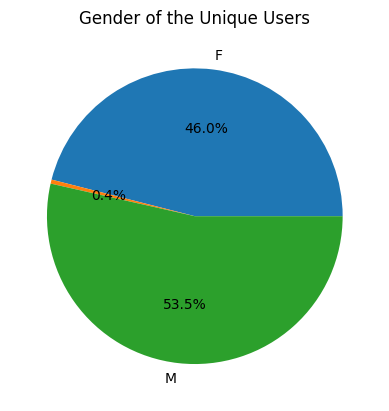

In [73]:
#How many unique users are there in the dataset and what is  their genders?

import matplotlib.pyplot as plt

# Create a DataFrame containing the user IDs and genders, drop duplicates to get unique users
user_df = spotify_df.select(["userId", "gender"]).dropDuplicates()

# Get the count of users by gender
gender_counts = user_df.groupBy("gender").count().toPandas()

# Create a pie chart to display the distribution of genders among unique users
plt.pie(gender_counts["count"], labels=gender_counts["gender"], autopct="%1.1f%%")
plt.title("Gender of the Unique Users")
plt.show()


<ipython-input-74-6e3c0a77b7a7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(page_counts_pd["page"], rotation=90)


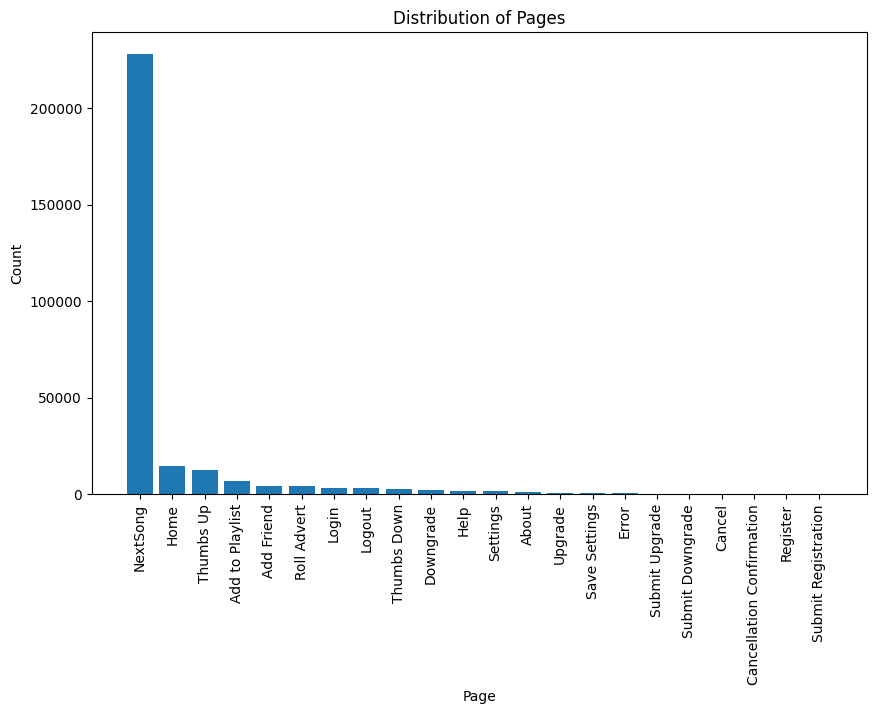

In [74]:
import matplotlib.pyplot as plt


page_counts = spotify_df.groupBy("page").count().orderBy("count", ascending=False)

# Convert to Pandas dataframe for plotting
page_counts_pd = page_counts.toPandas()

# Create bar plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(page_counts_pd["page"], page_counts_pd["count"])
ax.set_xticklabels(page_counts_pd["page"], rotation=90)
ax.set_xlabel("Page")
ax.set_ylabel("Count")
ax.set_title("Distribution of Pages")
plt.show()



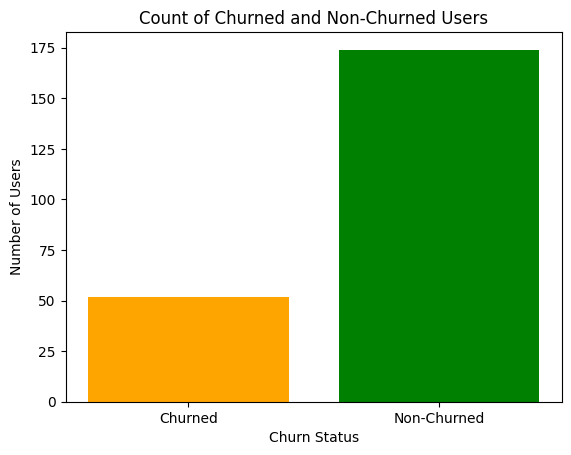

In [75]:
import matplotlib.pyplot as plt

# calculate number of churned and non-churned users
churn_count = spotify_df.filter(col("page") == "Cancellation Confirmation") \
                       .select("userId").distinct().count()
non_churn_count = spotify_df.select("userId").distinct().count() - churn_count

# create bar plot
colors = ['orange', 'green']
labels = ["Churned", "Non-Churned"]
values = [churn_count, non_churn_count]
plt.bar(labels, values,color=colors)
plt.xlabel("Churn Status")
plt.ylabel("Number of Users")
plt.title("Count of Churned and Non-Churned Users")
plt.show()


In [76]:
# Define a churn event as a user downgrading their subscription or cancelling their account
churn_event = when((col("page") == "Cancellation Confirmation") | (col("page") == "Downgrade"), 1).otherwise(0)

# Add the churn_event column to the DataFrame
spotify_df = spotify_df.withColumn("churn_event", churn_event)


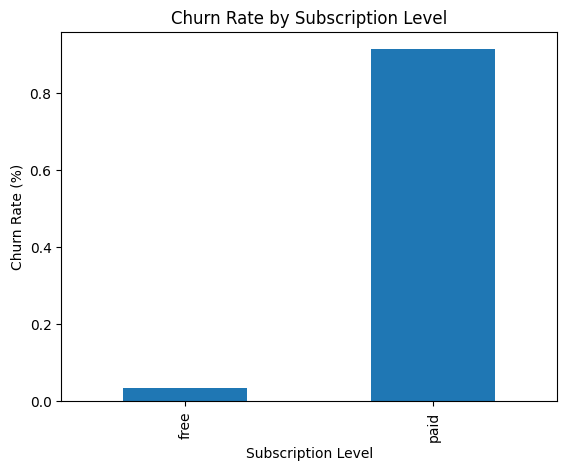

In [77]:
from pyspark.sql.functions import sum, when, col

# Calculate churn rate
churn_rate = spotify_df.groupBy("level").agg(
    (sum(when(col("churn_event") == 1, 1).otherwise(0)) / count("*") * 100).alias("churn_rate")
)

# Create plot of churn rate by subscription level
churn_rate.toPandas().plot(kind="bar", x="level", y="churn_rate", legend=False)
plt.title("Churn Rate by Subscription Level")
plt.xlabel("Subscription Level")
plt.ylabel("Churn Rate (%)")
plt.show()


In [78]:
churned_users = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])
# artist
df_user_artist = churned_users.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                                    .withColumn("churn", when(col("churn") == 1, "Churn").otherwise("Not Churn")).toPandas()
df_user_artist.head()

,userId,churn,artist_count
0,125,Churn,11
1,51,Churn,2464
2,124,Not Churn,4825
3,7,Not Churn,201
4,54,Churn,3437


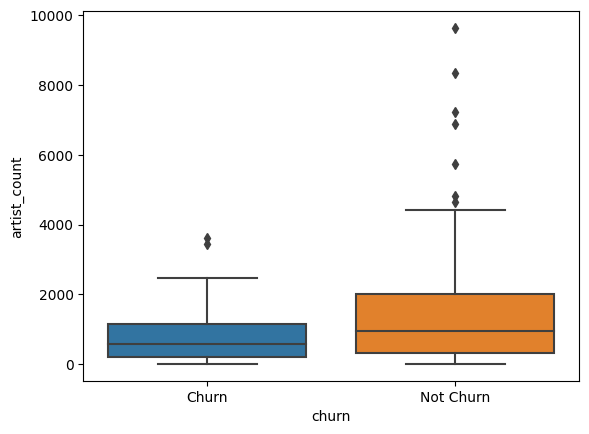

In [79]:
sns.boxplot(x="churn", y="artist_count", data=df_user_artist);


In [80]:
#song
df_user_song = churned_users.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", when(col("churn") == 1, "Churn").otherwise("Not Churn")).toPandas()
df_user_song.head()


,userId,churn,song_count
0,125,Churn,11
1,51,Churn,2464
2,124,Not Churn,4825
3,7,Not Churn,201
4,54,Churn,3437


<Axes: xlabel='churn', ylabel='song_count'>

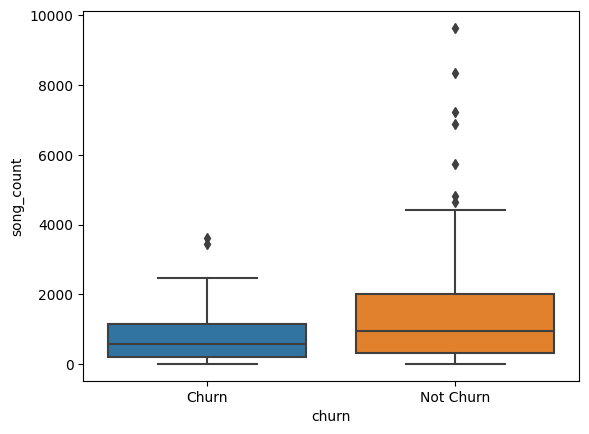

In [81]:
sns.boxplot(x="churn", y="song_count", data=df_user_song)

In [82]:
# page: total visits
df_user_visit = churned_users.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", when(col("churn") == 1, "Churn").otherwise("Not Churn")).toPandas()
df_user_visit.head()



,userId,churn,visit_count
0,125,Churn,11
1,51,Churn,2464
2,124,Not Churn,4825
3,7,Not Churn,201
4,54,Churn,3437


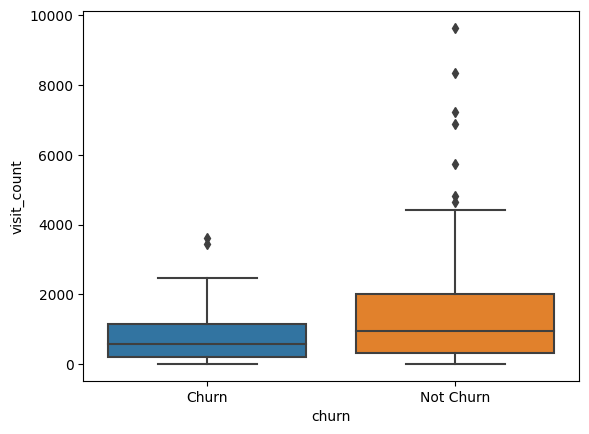

In [83]:
sns.boxplot(x="churn", y="visit_count", data=df_user_visit);

In [84]:
df_churn_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", when(col("churn") == 1, "Churn").otherwise("Not Churn")).toPandas()
df_churn_gender.head()

,userId,gender,churn
0,,None,Not Churn
1,,None,Not Churn
2,,None,Not Churn
3,,None,Not Churn
4,,None,Not Churn


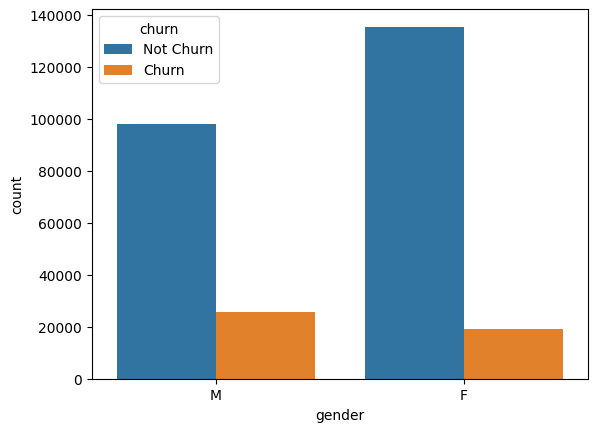

In [85]:
sns.countplot(x="gender", hue="churn", data=df_churn_gender);

In [86]:
# Feature Engineering

In [87]:
new_df_original = customer_event_df.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [88]:
new_df_original.show(10)

+------+------+
|userId|target|
+------+------+
|      |     0|
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     0|
|100003|     1|
|100004|     0|
|100005|     1|
|100006|     1|
|100007|     1|
+------+------+
only showing top 10 rows



In [89]:
artist_count = customer_event_df.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
artist_count.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|   125|          11|
|    51|        2464|
|   124|        4825|
|     7|         201|
|    54|        3437|
+------+------------+
only showing top 5 rows



In [90]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = customer_event_df.withColumn("gender", flag_gender("gender"))
df_churn_with_gender.show(1)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churn|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+
|Evanescence|Logged In|    Colin|     0|            0|  Larson|237.11302| paid|Dallas-Fort Worth...|   PUT|NextSong|1537982255000|      256|Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|    0|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------

In [91]:
#from pyspark.sql.functions import when

#df_churn_gender = customer_event_df.withColumn("gender", when(col("gender") == "M", 1).otherwise(0))
#df_churn_gender.show(1)


In [92]:
user_gender_count = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender_count.show(5)

+------+------+
|userId|gender|
+------+------+
|   125|     0|
|    51|     0|
|   124|     1|
|     7|     0|
|    54|     1|
+------+------+
only showing top 5 rows



In [93]:
# Length
user_total_length = customer_event_df.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_total_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899992|
|     7| 38034.08710000002|
|    54|  711344.919540001|
+------+------------------+
only showing top 5 rows



In [94]:
# Page
# Thubs up, thubs down
user_total_thumbs_up = customer_event_df.filter(customer_event_df["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_total_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|    51|     100|
|   124|     171|
|     7|       7|
|    54|     163|
|    15|      81|
+------+--------+
only showing top 5 rows



In [95]:
user_total_thumbs_down = customer_event_df.filter(customer_event_df["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_total_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|    51|        21|
|   124|        41|
|     7|         1|
|    15|        14|
|    54|        29|
+------+----------+
only showing top 5 rows



In [96]:
# Level
#flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
#df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
#df_churn_with_level.show(1)

In [97]:
# Level
from pyspark.sql.functions import when
churn_level = df_churn.withColumn("level", when(col("level") == "paid", 1).otherwise(0))
churn_level.show(1)


+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churned|phase|churn|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-------+-----+-----+
|Evanescence|Logged In|    Colin|     M|            0|  Larson|237.11302|    1|Dallas-Fort Worth...|   PUT|NextSong|1537982255000|      256|Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|      0|    0|    0|
+-----------+---------+---------+------+-------------+--------+---------+-----+-------------

In [98]:
user_level = churn_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|   125|    0|
|    51|    1|
|   124|    1|
|     7|    0|
|    54|    1|
+------+-----+
only showing top 5 rows



In [99]:
user_plan = churn_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_plan.show(5)


+------+-----+
|userId|level|
+------+-----+
|   125|    0|
|    51|    1|
|   124|    1|
|     7|    0|
|    54|    1|
+------+-----+
only showing top 5 rows



In [100]:
# Song count per userID
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|   125|        11|
|    51|      2464|
|   124|      4825|
|     7|       201|
|    54|      3437|
+------+----------+
only showing top 5 rows



In [101]:
#from pyspark.sql.functions import when

#user_churn = customer_event_df.withColumn("churn", when(col("page") == "Cancellation Confirmation", 1).otherwise(0)) \
#                              .groupBy("userId") \
#                              .agg({"churn": "max"}) \
#                              .withColumnRenamed("max(churn)", "churn")
#user_churn.show(5)


In [102]:
#from pyspark.sql.functions import expr

#user_churn = customer_event_df.selectExpr("userId", "CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS churn") \
#                              .groupBy("userId") \
#                              .agg(expr("max(churn) as churn"))
#user_churn.show(5)


In [103]:
# Joining all the features
final_df = new_df_original.join(artist_count, ['userId']) \
    .join(user_gender_count, ['userId']) \
    .join(user_total_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_total_thumbs_up, ['userId']) \
    .join(user_total_thumbs_down, ['userId']) \
    .join(user_song, ['userId']) \
#    .join(user_churn, ['userID'])

In [104]:
final_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|    51|     1|        2464|     0| 523275.8428000004|    1|     100|        21|      2464|
|   124|     0|        4825|     1|1012312.0927899992|    1|     171|        41|      4825|
|     7|     0|         201|     0| 38034.08710000002|    0|       7|         1|       201|
|    54|     1|        3437|     1|  711344.919540001|    1|     163|        29|      3437|
|    15|     0|        2278|     0|477307.60581000056|    1|      81|        14|      2278|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



In [105]:
final_df.write.csv("final_df.csv", header=True, mode="overwrite")

In [106]:
print("Number of rows:", final_df.count())

# Print the number of columns in the DataFrame
print("Number of columns:", len(final_df.columns))

Number of rows: 202
Number of columns: 9


In [107]:
# Modelling
# Dropping UserID column
final_df_without_user = final_df.drop("userId")
feature_columns = [col for col in final_df_without_user.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

In [108]:
train, test = final_df_without_user.randomSplit([0.7, 0.3], seed = 100)


In [109]:
final_df_without_user.printSchema()

root
 |-- target: long (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- thumb_up: long (nullable = false)
 |-- thumb_down: long (nullable = false)
 |-- song_count: long (nullable = false)



In [110]:
print(train.count(),len(train.columns))
print(test.count(),len(test.columns))



142 8
60 8


In [111]:
# Define the feature columns
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the pipeline stages
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Define the hyperparameters to tune
param_grid = ParamGridBuilder().build()

# Define the cross-validation process
evaluator = MulticlassClassificationEvaluator(labelCol='target', metricName='f1')
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Train the model
cv_model = cv.fit(train)

# Make predictions on the test data
predictions = cv_model.transform(test)

# Evaluate the model performance
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))

F1 score: 0.6882


In [112]:
# Model without hyper-parameter
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
pipeline = Pipeline(stages=[assembler, scaler, lr])
lr1 = pipeline.fit(train)
predictions = lr1.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))

F1 score: 0.6882


In [113]:
# Checking for model to export

In [114]:
feature_cols2 = final_df_without_user.columns[1:]

assembler2 = VectorAssembler(inputCols=feature_cols2, outputCol="features")

model_df = assembler.transform(final_df_without_user).select("features", "target")

In [115]:
train_data, test_data = model_df.randomSplit([0.7, 0.3], seed=42)

In [116]:
lr = LogisticRegression(featuresCol="features", labelCol="target")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))

F1 score: 0.5884


In [117]:
best_model_path = 'models/lr_model'
lr_model.save(best_model_path)


In [118]:
!zip -r /content/models/lr_model.zip /content/models/lr_model

  adding: content/models/lr_model/ (stored 0%)
  adding: content/models/lr_model/data/ (stored 0%)
  adding: content/models/lr_model/data/part-00000-76c8517e-7768-4d0c-8f91-a5c9203d1901-c000.snappy.parquet (deflated 68%)
  adding: content/models/lr_model/data/.part-00000-76c8517e-7768-4d0c-8f91-a5c9203d1901-c000.snappy.parquet.crc (stored 0%)
  adding: content/models/lr_model/data/_SUCCESS (stored 0%)
  adding: content/models/lr_model/data/._SUCCESS.crc (stored 0%)
  adding: content/models/lr_model/metadata/ (stored 0%)
  adding: content/models/lr_model/metadata/.part-00000.crc (stored 0%)
  adding: content/models/lr_model/metadata/part-00000 (deflated 43%)
  adding: content/models/lr_model/metadata/_SUCCESS (stored 0%)
  adding: content/models/lr_model/metadata/._SUCCESS.crc (stored 0%)


In [119]:
import pandas as pd

# Get coefficients and feature names
coefficients = cv_model.bestModel.stages[-1].coefficients.toArray()
feature_names = assembler.getInputCols()

# Create a pandas dataframe with feature names and coefficients
df_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort dataframe by absolute value of coefficients in descending order
df_coefficients = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Print dataframe
print(df_coefficients)



        Feature  Coefficient
2        length   -40.444739
0  artist_count    21.814823
6    song_count    21.814823
4      thumb_up    -9.812459
5    thumb_down     1.046980
3         level     0.671533
1        gender    -0.397468


In [120]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define the feature columns
feature_columns = train.columns[2:]

# Define the pipeline stages
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
#label_indexer = StringIndexer(inputCol="target", outputCol="indexed_label").fit(train)
#feature_indexer = VectorIndexer(inputCol="features", outputCol="indexed_features").fit(train)
rf = RandomForestClassifier(labelCol="target", featuresCol="scaled_features")
# pipeline = Pipeline(stages=[assembler, label_indexer, feature_indexer, rf])
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Define the hyperparameters to tune
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define the cross-validation process
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Train the model
cv_model = cv.fit(train)

# Make predictions on the test data
predictions = cv_model.transform(test)

# Evaluate the model performance
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))


F1 score: 0.7240


In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import Pipeline

# Define the feature columns
#feature_columns = train.columns[2:]

# Define the pipeline stages
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
gbt = GBTClassifier(labelCol="target", featuresCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler, gbt])

# Define the hyperparameters to tune
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .build()

# Define the cross-validation process
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Train the model
cv_model = cv.fit(train)

# Make predictions on the test data
predictions = cv_model.transform(test)

# Evaluate the model performance
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import Pipeline

# Define the feature columns
feature_columns = train.columns[2:]

# Define the pipeline stages
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
svm = LinearSVC(labelCol="target", featuresCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler, svm])

# Define the hyperparameters to tune
param_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .build()

# Define the cross-validation process
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Train the model
cv_model = cv.fit(train)

# Make predictions on the test data
predictions = cv_model.transform(test)

# Evaluate the model performance
f1_score = evaluator.evaluate(predictions)
print("F1 score: {:.4f}".format(f1_score))
